In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr 25 06:10:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
! pip install keras --upgrade
! pip install tensorflow --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc3)


In [0]:
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, optimizers, utils, regularizers
#from tensorflow.keras.engine.input_layer import Input

import pandas as pd

In [0]:
import pickle

In [0]:
blnLoaData =  True
blnBuildModel = False

##Load binary files.  This is faster than loading from JPG files

In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
binary_flder = '/content/drive/Shared drives/DS8013/Data/Binary/'

In [0]:
X = np.load(binary_flder + 'X.npy')
y = np.load(binary_flder + 'y.npy')
y_onehot = np.load(binary_flder + 'y_onehot.npy')

In [7]:
X.shape

(27000, 64, 64, 3)

In [0]:
X = X/255 #normlize images

In [9]:
y_onehot.shape

(27000, 10)

In [0]:
unique_elements, counts_elements = np.unique(y, return_counts=True)

In [11]:
(list(zip(unique_elements, counts_elements)))

[('AnnualCrop', 3000),
 ('Forest', 3000),
 ('HerbaceousVegetation', 3000),
 ('Highway', 2500),
 ('Industrial', 2500),
 ('Pasture', 2000),
 ('PermanentCrop', 2500),
 ('Residential', 3000),
 ('River', 2500),
 ('SeaLake', 3000)]

##Split to train and test

In [0]:
# split data set into test and training using 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X,y_onehot,test_size = 0.2, random_state = 197)

X_flatten_train = X_train.flatten().reshape(len(X_train), 12288) # flatten 64*64*3 = 12288
X_flatten_test = X_test.flatten().reshape(len(X_test), 12288) # flatten 64*64*3 = 12288

In [13]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
(list(zip(unique_elements, counts_elements)))

[(0.0, 194400), (1.0, 21600)]

##Simple Model

Converges too slowly with learning rate 1e-6 and 15,000 hidden units.  With a higher learning rate (1e-3), the accuracy drops significatly and does not appear to converge

In [0]:
## Simple ANN Model

model_flder = '/content/drive/Shared drives/DS8013/Model/'

if blnBuildModel:
  models = []
  MLPmodels = []
  for numUnits in [1000, 5000]:
    for numLayers in [1,2,3]:
      for actFunc in ['relu', 'tanh']:
        for lr in [ 1e-4, 1e-5]:
          print()
          print('numUnits:{0}  numLayers:{1}  actFunc:{2}  learn_rate:{3}'.format(numUnits, numLayers, actFunc, lr))

          #Instantiate an empty model
          model = Sequential()

          #Fully Connected Layer
          for i in range(numLayers):
            model.add(layers.Dense(numUnits, activation=actFunc, kernel_regularizer=regularizers.l2(0.001)))

          #Output Layer with softmax activation
          model.add(layers.Dense(10, activation="softmax"))

          #optimizer
          sgd = optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)

          # Compile the model
          model.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])
          
          hist = model.fit(X_flatten_train, y_train, epochs=50, validation_data = (X_flatten_test, y_test), verbose=1)
          
          modelName = 'MLP_{0}_{1}_{2}_{3}.mdl'.format(numUnits, numLayers, actFunc, lr)
          model.save(model_flder + modelName)

          MLPmodels.append(model)
          models.append({'model':modelName, 'learn_rate':lr, 'activation':actFunc, 'numLayers':numLayers, 'numUnits':numUnits, 'hist':hist.history})

          pickle.dump(models, open(model_flder + 'normal_mlp_models.p' , "wb" ) )

else:
  models = pickle.load(open(model_flder + 'normal_mlp_models.p', 'rb'))

In [25]:
# Comparison of all models

modelAccuracy = [m['hist']['val_accuracy'][49] for m in models ]
modelLoss = [m['hist']['val_loss'][49] for m in models ]
modelName = [m['model'] for i,m in enumerate(models) ]

df = pd.DataFrame({'model':modelName, 'accuracy':modelAccuracy, 'loss':modelLoss})
df = df.sort_values('accuracy', ascending=False)

df

,model,accuracy,loss
20,MLP_5000_3_relu_0.0001.mdl,0.622222,16.065479
16,MLP_5000_2_relu_0.0001.mdl,0.606481,11.764502
8,MLP_1000_3_relu_0.0001.mdl,0.605741,4.534799
10,MLP_1000_3_tanh_0.0001.mdl,0.596482,4.556111
6,MLP_1000_2_tanh_0.0001.mdl,0.591482,3.741327
22,MLP_5000_3_tanh_0.0001.mdl,0.591296,16.168186
18,MLP_5000_2_tanh_0.0001.mdl,0.566296,11.859963
12,MLP_5000_1_relu_0.0001.mdl,0.564444,7.504574
4,MLP_1000_2_relu_0.0001.mdl,0.557037,3.734782
2,MLP_1000_1_tanh_0.0001.mdl,0.554074,2.932270


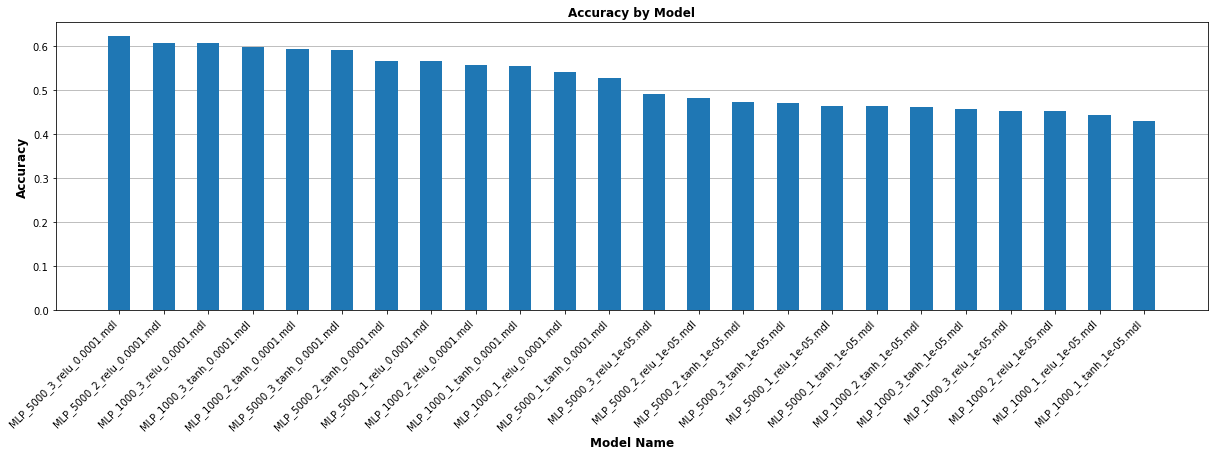

In [27]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_axes([0,0,1,1])
ax.grid(axis='y', which='both')
ax.set_axisbelow(True)
ax.bar(df.model,df.accuracy, width=0.5)
ax.set_ylabel('Accuracy', fontsize='large', fontweight='bold')
ax.set_xlabel('Model Name', fontsize='large', fontweight='bold')
ax.set_title('Accuracy by Model', fontsize='large', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

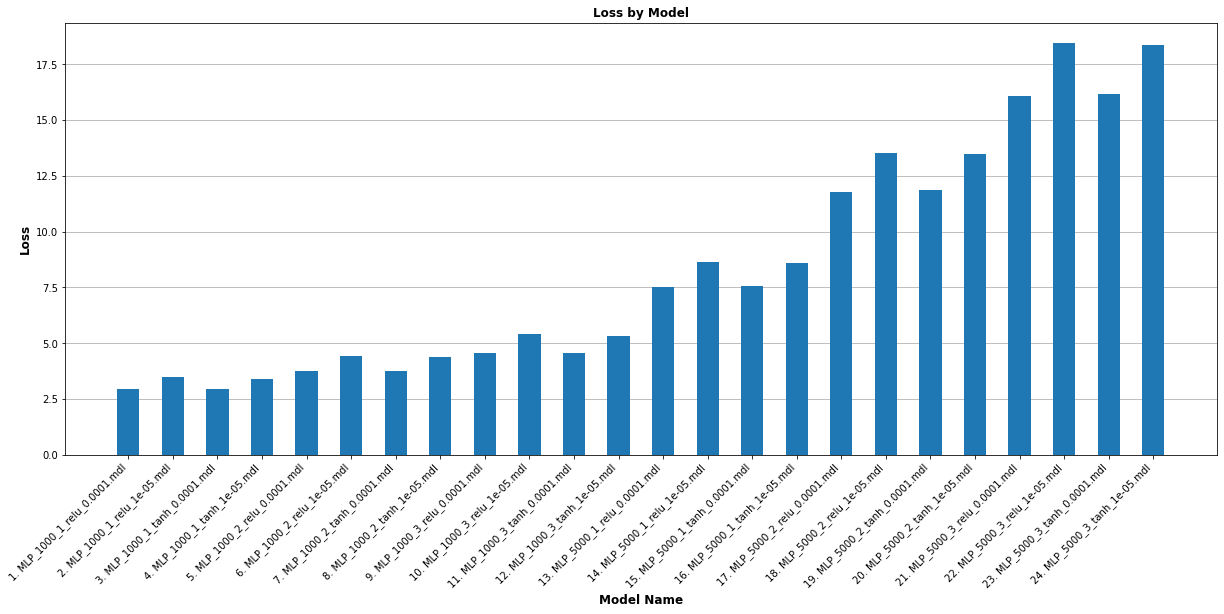

In [0]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
ax.grid(axis='y', which='both')
ax.set_axisbelow(True)
ax.bar(modelName,modelLoss, width=0.5)
ax.set_ylabel('Loss', fontsize='large', fontweight='bold')
ax.set_xlabel('Model Name', fontsize='large', fontweight='bold')
ax.set_title('Loss by Model', fontsize='large', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

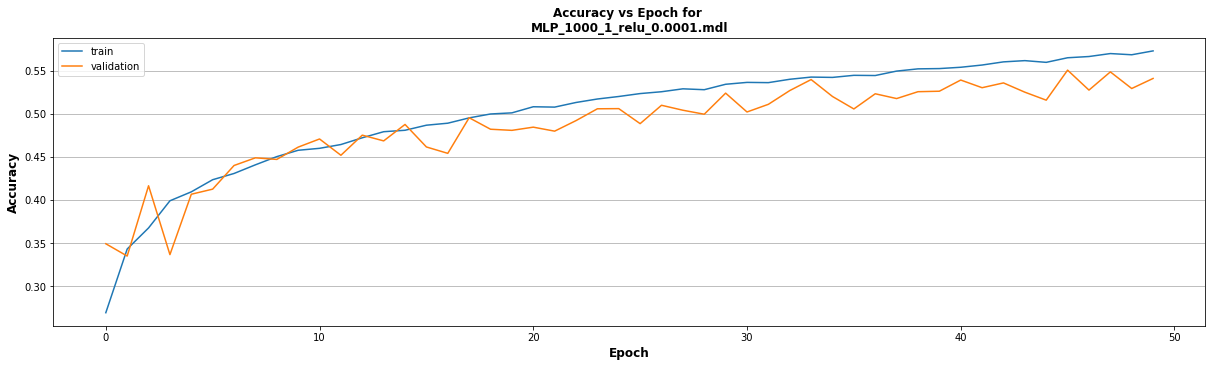

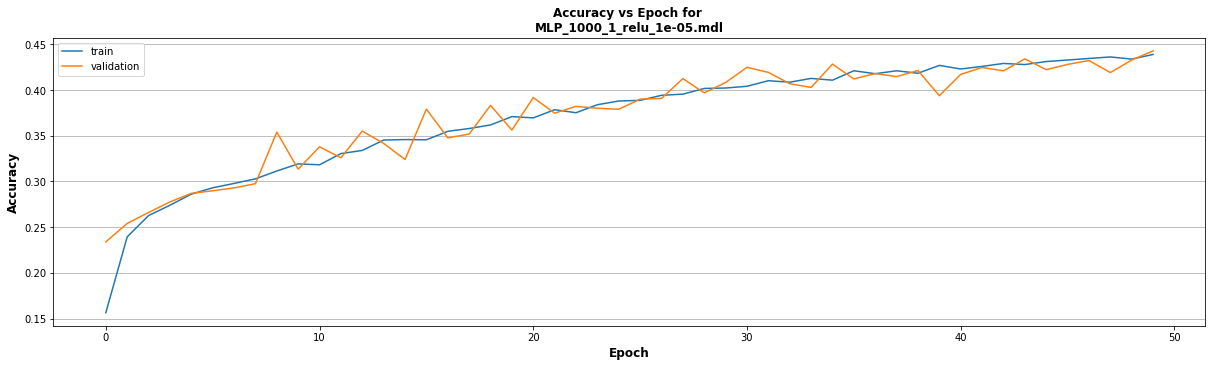

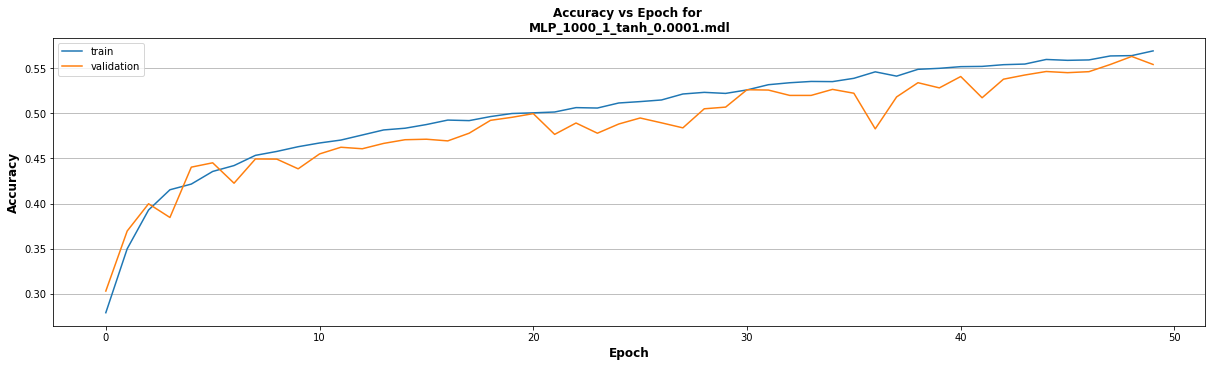

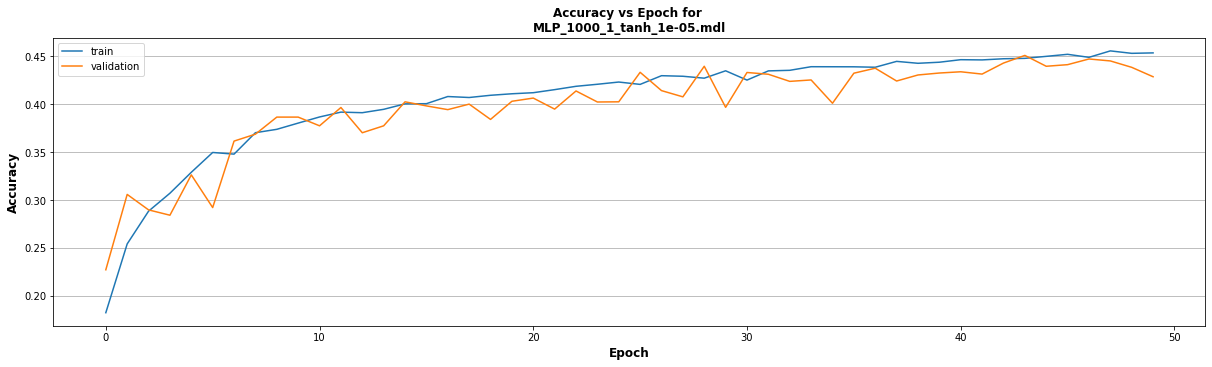

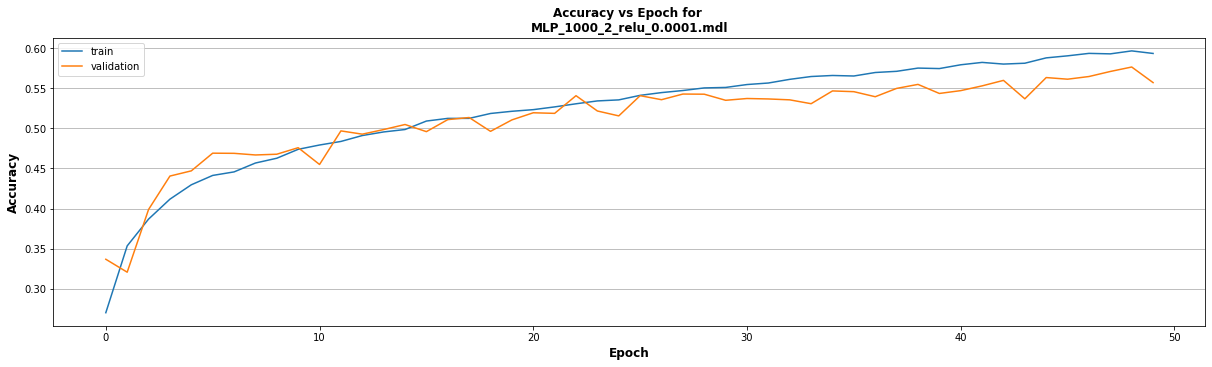

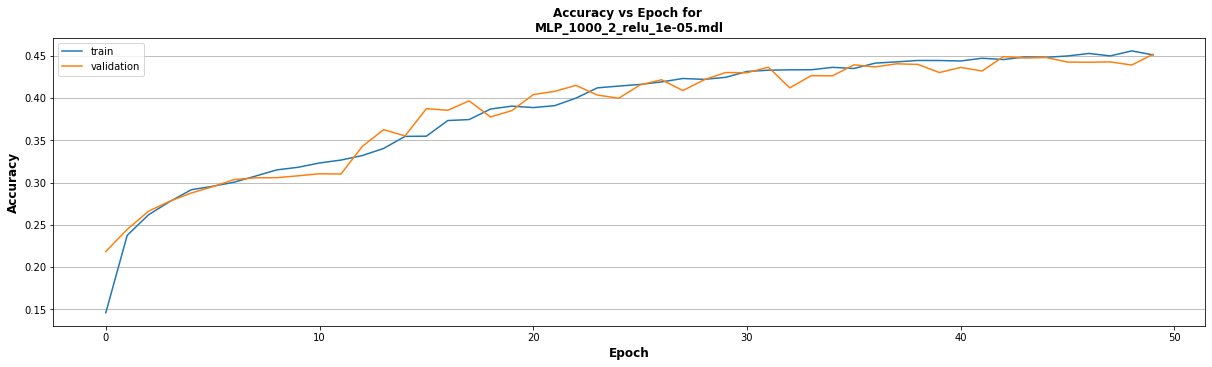

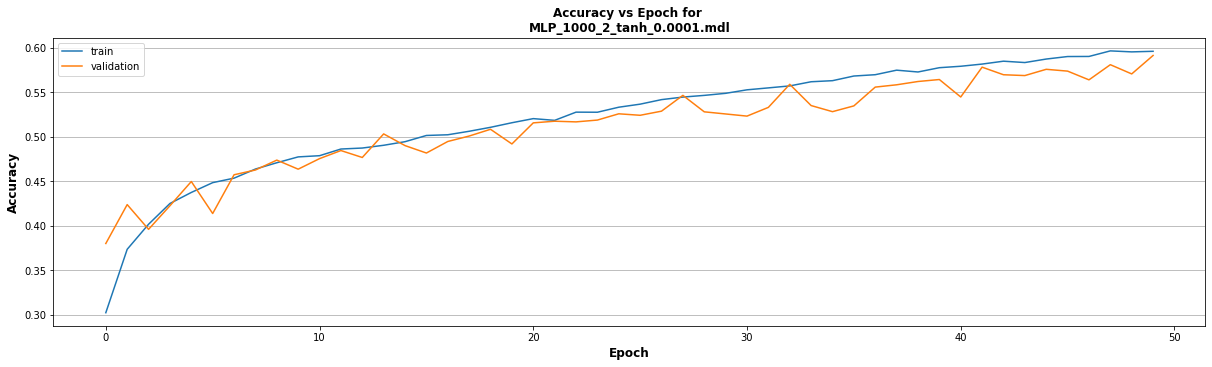

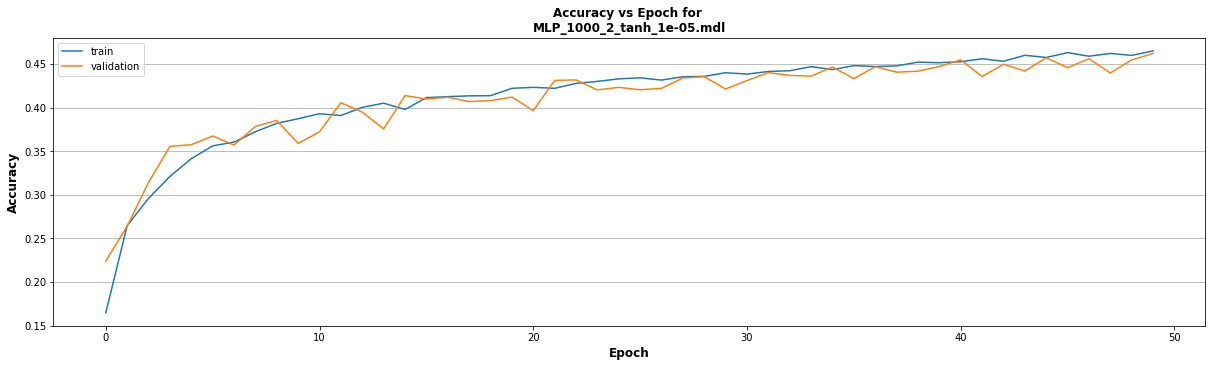

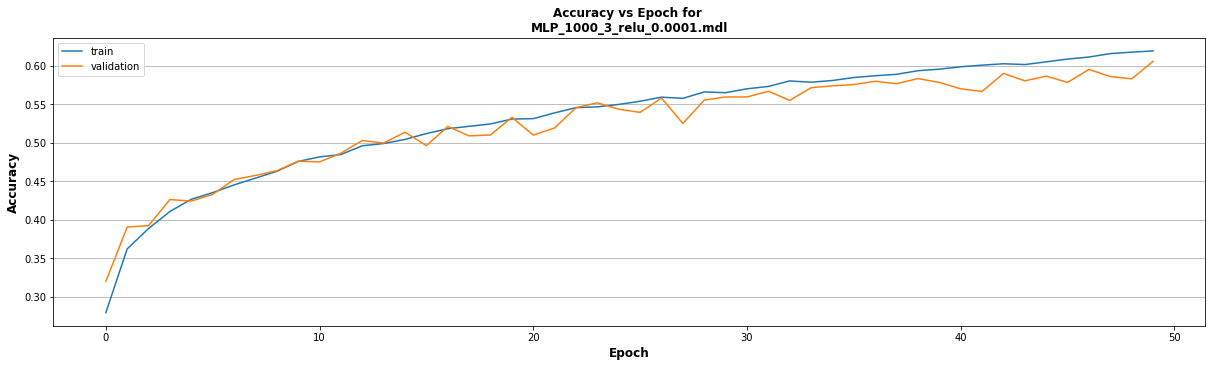

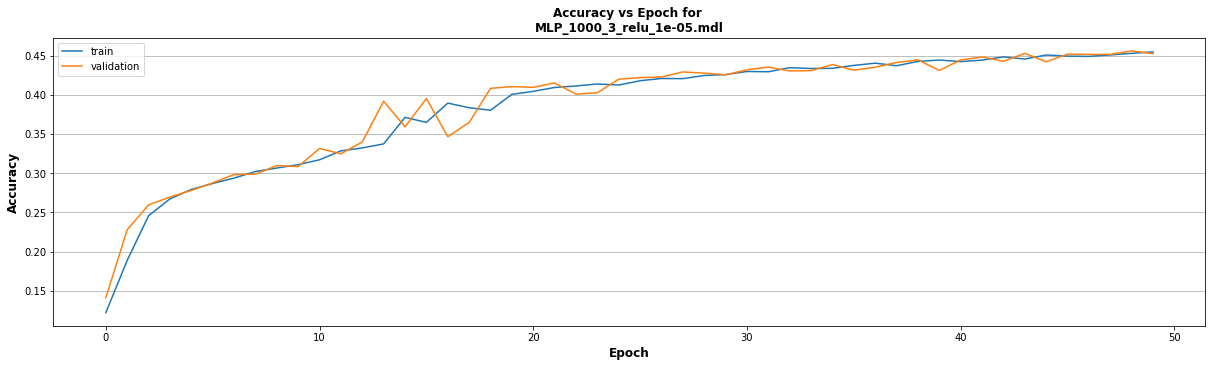

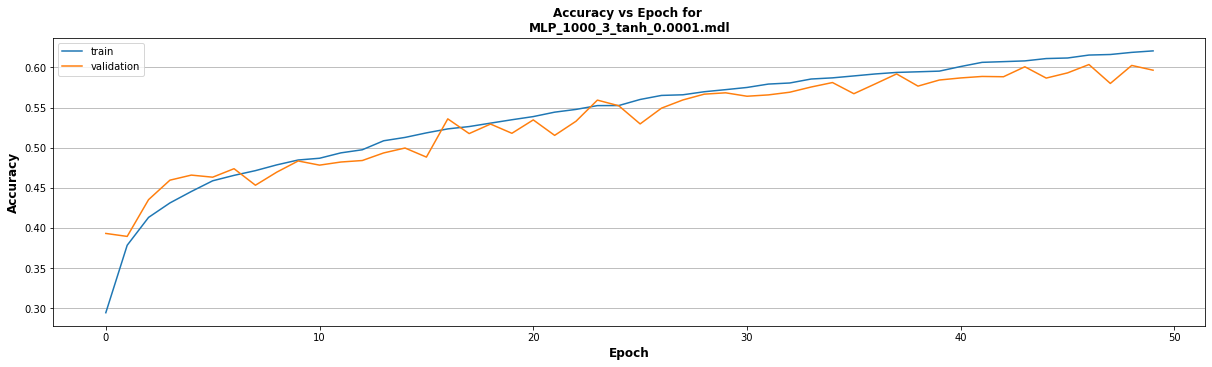

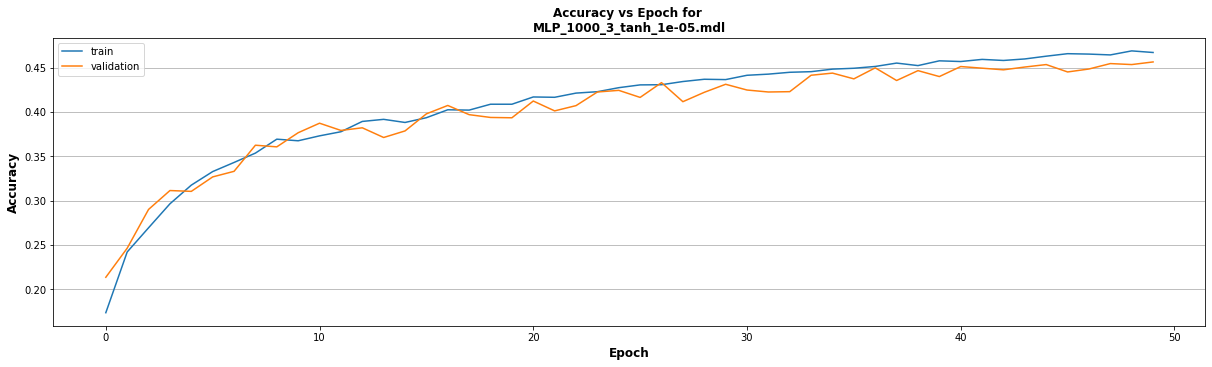

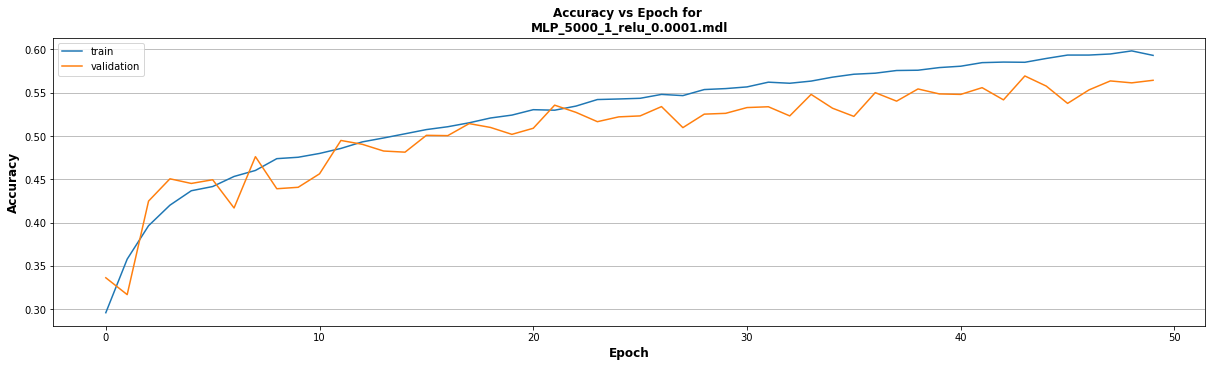

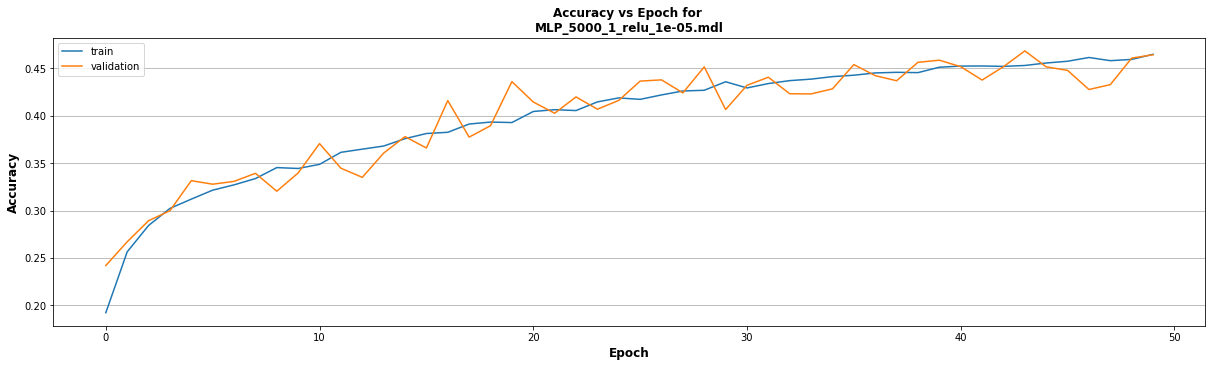

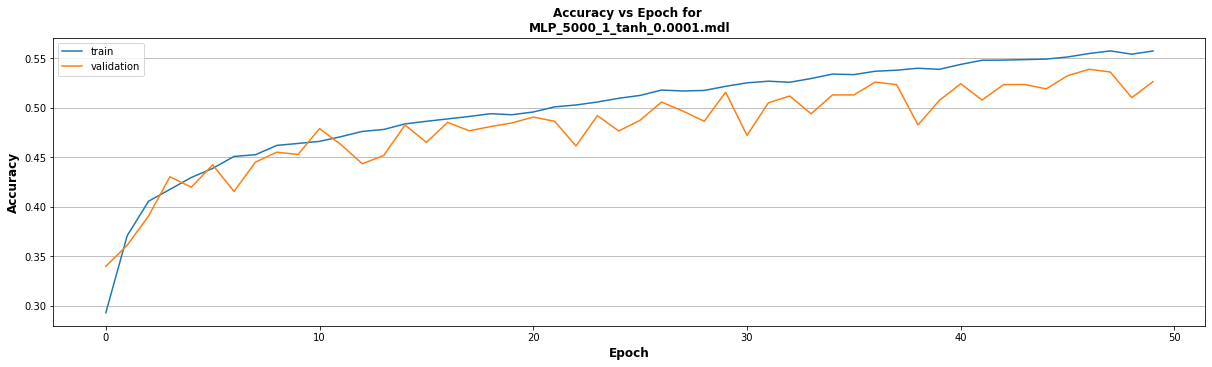

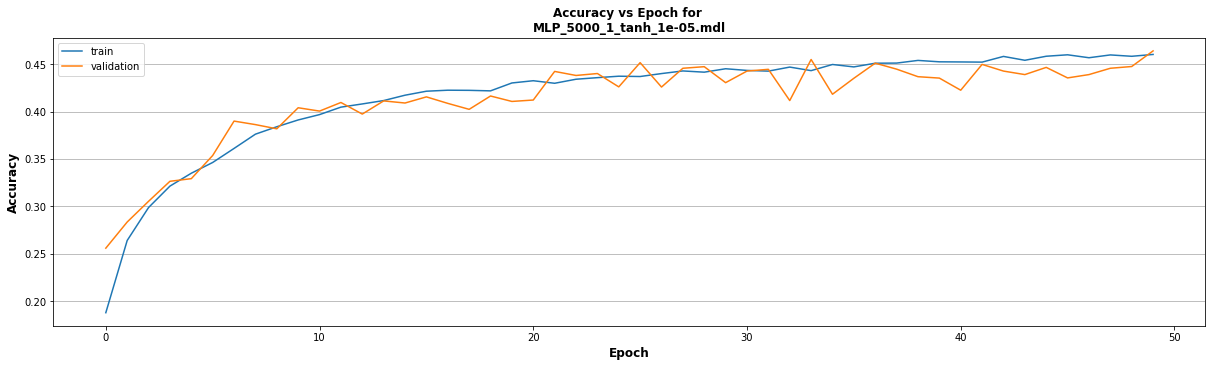

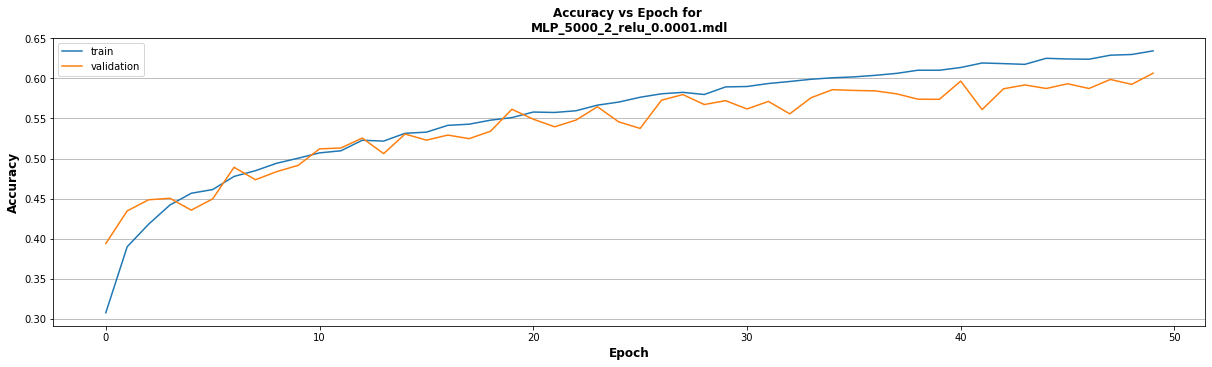

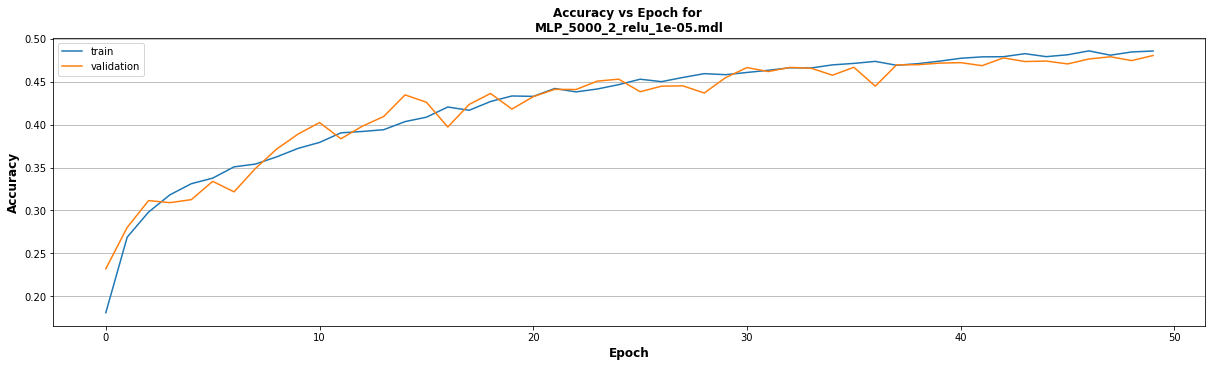

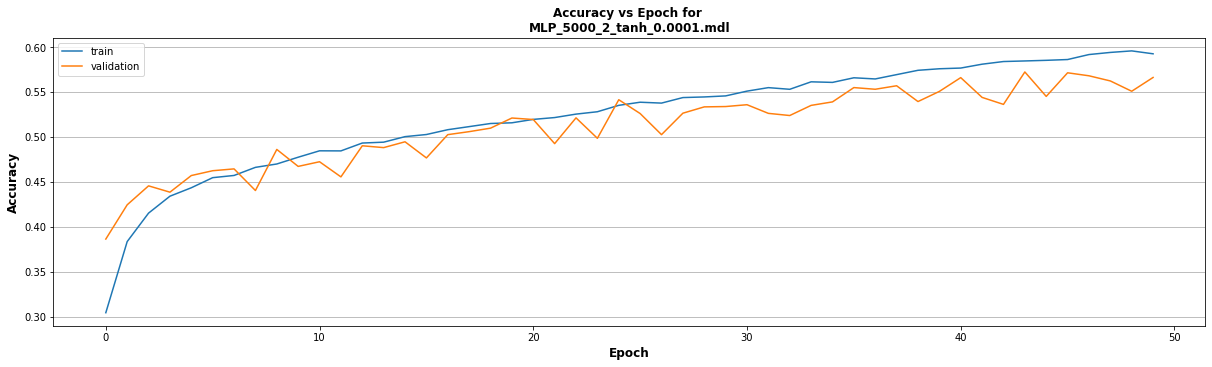

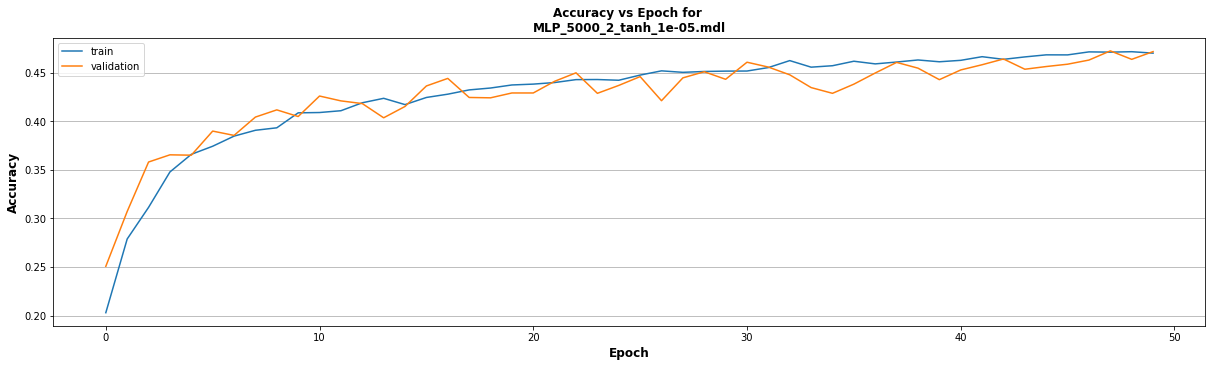

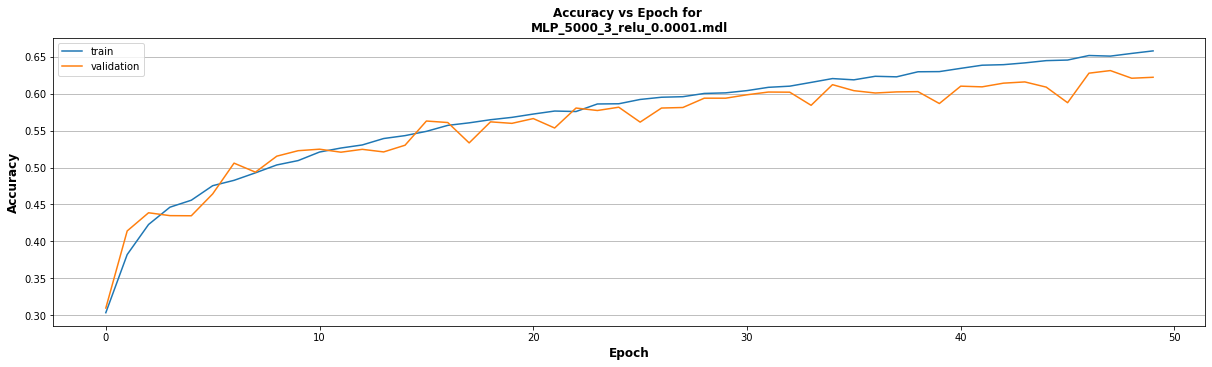

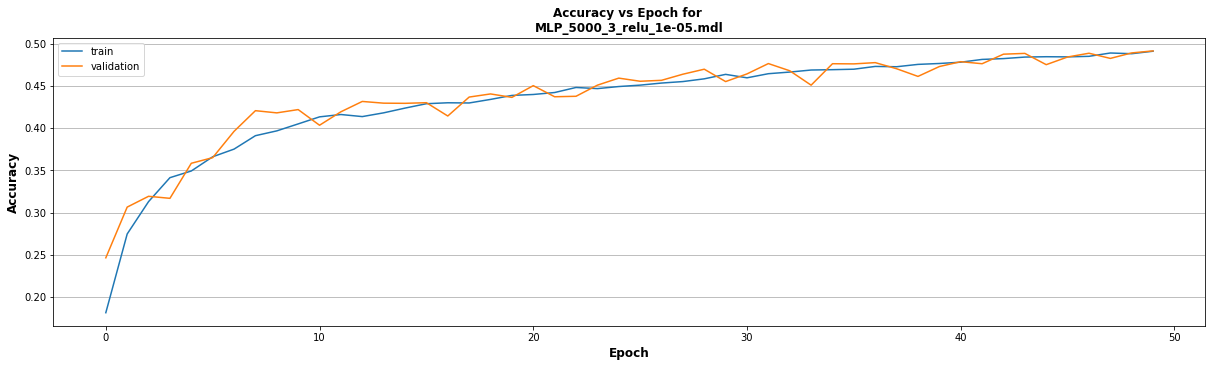

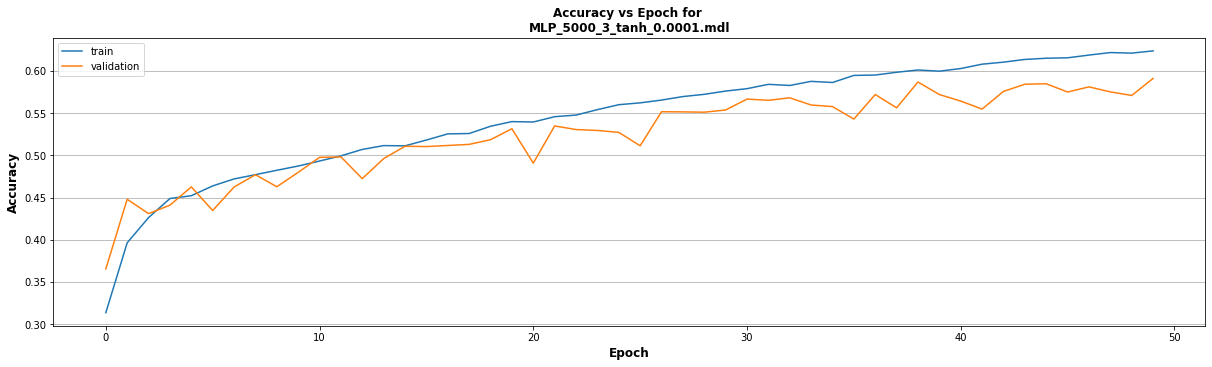

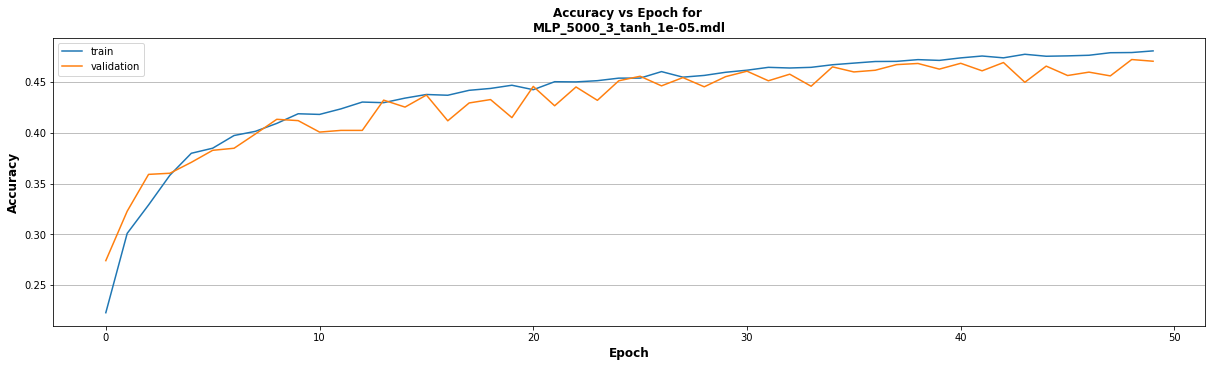

In [29]:
# Comparison of number of layers

#models.append({'model':modelName, 'learn_rate':lr, 'activation':actFunc, 'numLayers':numLayers, 'numUnits':numUnits, 'hist':hist.history})
for modelIndex in range(len(models)):
  histAcc = models[modelIndex]['hist']['accuracy']
  histValAcc = models[modelIndex]['hist']['val_accuracy']


  fig = plt.figure(figsize=(16,4))
  ax = fig.add_axes([0,0,1,1])
  ax.grid(axis='y', which='both')
  ax.set_axisbelow(True)
  ax.set_ylabel('Accuracy', fontsize='large', fontweight='bold')
  ax.set_xlabel('Epoch', fontsize='large', fontweight='bold')
  ax.set_title('Accuracy vs Epoch for \n' +  models[modelIndex]['model'] , fontsize='large', fontweight='bold')
  
  plt.plot(histAcc)
  plt.plot(histValAcc)
  ax.legend(['train', 'validation'])
  plt.show()



In [0]:
test_score = model.evaluate(X_flatten_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

169/169 [==============================] - 1s 6ms/step - loss: 18.3723 - accuracy: 0.4706
Test loss 18.3723, accuracy 47.06%


### 3 Layer CNN with 3x3 filter


In [0]:

#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(8, kernel_size=(3,3), strides=(1,1), input_shape=(64,64,3), activation='relu'))

# C2 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu'))

# C3 Convolutional Layer
model.add(layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(4), strides=(2) ))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='sigmoid'))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation="softmax"))

# #optimizer
sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])


In [0]:
model.fit(
  X_train, # training data
  y_train, # training targets
  epochs=120,
  batch_size=16, use_multiprocessing=True
)

Epoch 1/120
21600/21600 [==============================] - 15s 689us/step - loss: 2.0979 - accuracy: 0.2240
Epoch 2/120
21600/21600 [==============================] - 15s 679us/step - loss: 1.8477 - accuracy: 0.3196
Epoch 3/120
21600/21600 [==============================] - 15s 683us/step - loss: 1.5532 - accuracy: 0.4710
Epoch 4/120
21600/21600 [==============================] - 15s 679us/step - loss: 1.3445 - accuracy: 0.5681
Epoch 5/120
21600/21600 [==============================] - 15s 680us/step - loss: 1.2066 - accuracy: 0.6187
Epoch 6/120
21600/21600 [==============================] - 15s 679us/step - loss: 1.0876 - accuracy: 0.6565
Epoch 7/120
21600/21600 [==============================] - 15s 695us/step - loss: 0.9847 - accuracy: 0.6991
Epoch 8/120
21600/21600 [==============================] - 15s 679us/step - loss: 0.8993 - accuracy: 0.7311
Epoch 9/120
21600/21600 [==============================] - 15s 680us/step - loss: 0.8264 - accuracy: 0.7525
Epoch 10/120
21600/21600 [==

In [0]:
test_score = model.evaluate(X_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

5400/5400 [==============================] - 1s 232us/step
Test loss 0.6078, accuracy 81.13%


## Another 3 layer CNN

In [0]:

#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), input_shape=(64,64,3), activation='relu'))

# C2 Convolutional Layer
model.add(layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu'))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(4), strides=(2) ))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(96, activation='sigmoid'))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation="softmax"))

# #optimizer
sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])


In [0]:
hist = model.fit(
  X_train, # training data
  y_train, # training targets
  epochs=120,
  batch_size=16, use_multiprocessing=True
)

Epoch 1/120
21600/21600 [==============================] - 21s 972us/step - loss: 1.9153 - accuracy: 0.2887
Epoch 2/120
21600/21600 [==============================] - 21s 961us/step - loss: 1.6369 - accuracy: 0.4325
Epoch 3/120
21600/21600 [==============================] - 21s 968us/step - loss: 1.3994 - accuracy: 0.5279
Epoch 4/120
21600/21600 [==============================] - 21s 964us/step - loss: 1.2534 - accuracy: 0.5732
Epoch 5/120
21600/21600 [==============================] - 21s 964us/step - loss: 1.1645 - accuracy: 0.6124
Epoch 6/120
21600/21600 [==============================] - 21s 965us/step - loss: 1.0869 - accuracy: 0.6394
Epoch 7/120
21600/21600 [==============================] - 21s 973us/step - loss: 1.0131 - accuracy: 0.6652
Epoch 8/120
21600/21600 [==============================] - 21s 951us/step - loss: 0.9393 - accuracy: 0.6972
Epoch 9/120
21600/21600 [==============================] - 21s 965us/step - loss: 0.8739 - accuracy: 0.7173
Epoch 10/120
21600/21600 [==

In [0]:
test_score = model.evaluate(X_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

ValueError: ignored

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 32)        18464     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 58, 58, 16)        4624      
_________________________________________________________________
average_pooling2d_4 (Average (None, 28, 28, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 96)                1204320   
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

##Padding


In [0]:
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), input_shape=(64,64,3), activation='relu', padding='same'))

# C2 Convolutional Layer
model.add(layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(4), strides=(2) ))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(96, activation='sigmoid'))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation="softmax"))

# #optimizer
sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])

In [0]:
hist = model.fit(
  X_train, # training data
  y_train, # training targets
  epochs=100,
  batch_size=32, use_multiprocessing=True
)

Epoch 1/100
21600/21600 [==============================] - 17s 808us/step - loss: 1.9228 - accuracy: 0.3110
Epoch 2/100
21600/21600 [==============================] - 17s 775us/step - loss: 1.6800 - accuracy: 0.4180
Epoch 3/100
21600/21600 [==============================] - 17s 780us/step - loss: 1.5545 - accuracy: 0.4715
Epoch 4/100
21600/21600 [==============================] - 17s 781us/step - loss: 1.4379 - accuracy: 0.5114
Epoch 5/100
21600/21600 [==============================] - 17s 781us/step - loss: 1.3372 - accuracy: 0.5555
Epoch 6/100
21600/21600 [==============================] - 17s 781us/step - loss: 1.2527 - accuracy: 0.5844
Epoch 7/100
21600/21600 [==============================] - 17s 778us/step - loss: 1.1769 - accuracy: 0.6120
Epoch 8/100
21600/21600 [==============================] - 17s 780us/step - loss: 1.1165 - accuracy: 0.6355
Epoch 9/100
21600/21600 [==============================] - 17s 784us/step - loss: 1.0639 - accuracy: 0.6539
Epoch 10/100
21600/21600 [==

In [0]:
test_score = model.evaluate(X_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

ValueError: ignored

In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 16)        4624      
_________________________________________________________________
average_pooling2d_6 (Average (None, 31, 31, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 15376)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 96)                1476192   
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

##Another model

In [0]:
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), input_shape=(64,64,3), activation='relu', padding='same'))

# C2 Convolutional Layer
model.add(layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))

# C3 Convolutional Layer
model.add(layers.Conv2D(8, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(4), strides=(2) ))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(96, activation='sigmoid'))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation="softmax"))

# #optimizer
sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])

In [0]:
hist = model.fit(
  x=X_train, # training data
  y=y_train, # training targets
  epochs=120,
  batch_size=32,
  use_multiprocessing=True,
  validation_data=(X_test, y_test)
)

21600/21600 [==============================] - 16s 745us/step - loss: 2.1526 - accuracy: 0.2263 - val_loss: 1.9490 - val_accuracy: 0.2946
Epoch 2/120
21600/21600 [==============================] - 16s 727us/step - loss: 1.8977 - accuracy: 0.3191 - val_loss: 1.8244 - val_accuracy: 0.3398
Epoch 3/120
21600/21600 [==============================] - 16s 723us/step - loss: 1.7989 - accuracy: 0.3706 - val_loss: 1.7408 - val_accuracy: 0.4050
Epoch 4/120
21600/21600 [==============================] - 16s 726us/step - loss: 1.7091 - accuracy: 0.4153 - val_loss: 1.6921 - val_accuracy: 0.3885
Epoch 5/120
21600/21600 [==============================] - 16s 722us/step - loss: 1.6329 - accuracy: 0.4425 - val_loss: 1.5861 - val_accuracy: 0.4628
Epoch 6/120
21600/21600 [==============================] - 16s 729us/step - loss: 1.5541 - accuracy: 0.4749 - val_loss: 1.5296 - val_accuracy: 0.4787
Epoch 7/120
21600/21600 [==============================] - 16s 729us/step - loss: 1.4999 - accuracy: 0.4995 - va

In [0]:
hist.history

##View sample

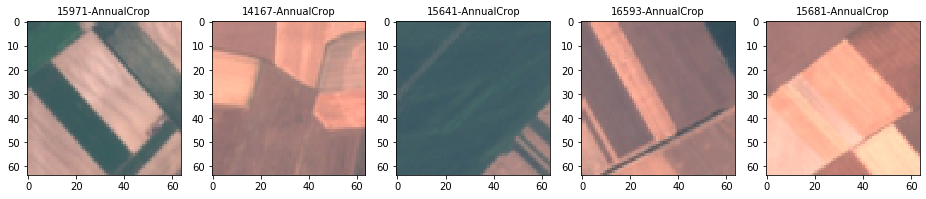

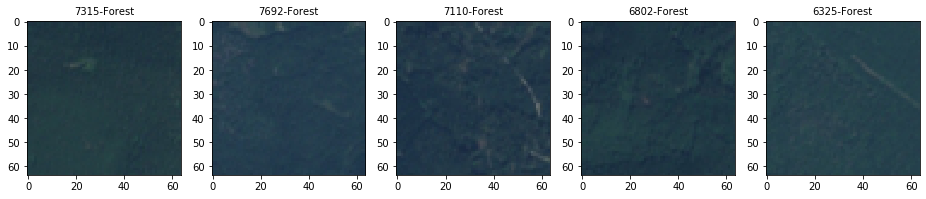

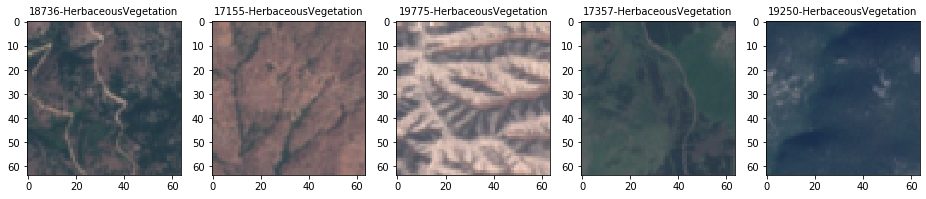

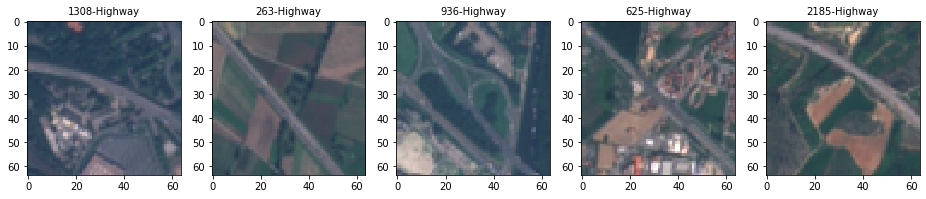

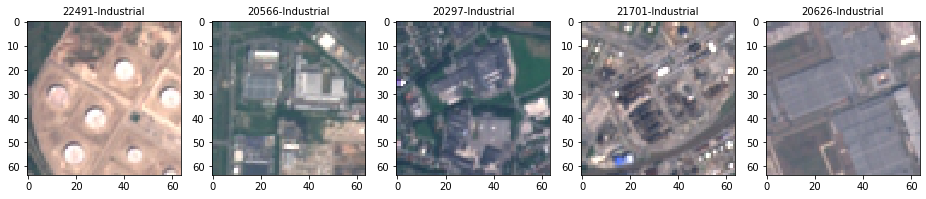

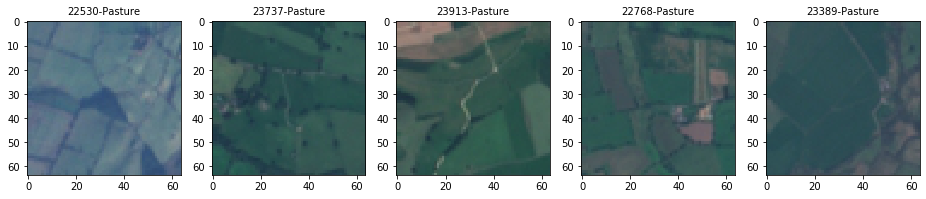

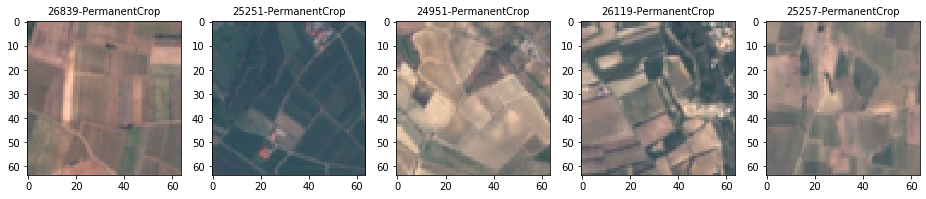

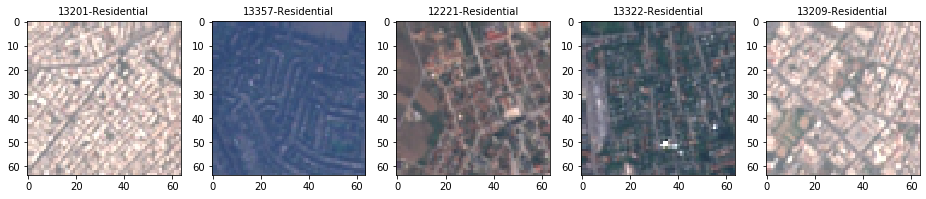

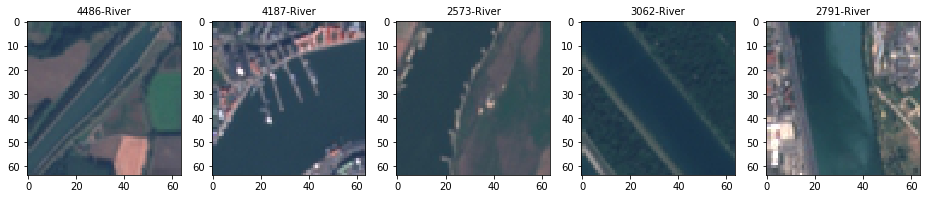

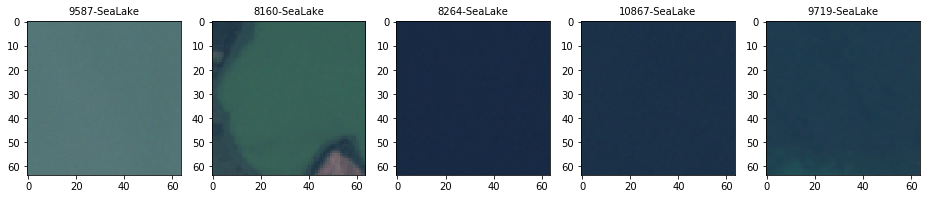

In [0]:
image_classes = unique_elements
rdm_size = 5

y_onehot = np.load(binary_flder + 'y_onehot.npy')
image_classes =  np.unique(le.inverse_transform(argmax(y_onehot, axis=1)))

for image_class in image_classes:
  
  #get the indices of each image class.  
  result = np.where(y == image_class)  #result is a tuple of arrays (one for each axis)
  
  idx_list = result[0]

  #view random images
  rdm_idx_list =  np.random.randint(low=idx_list[0], high=idx_list[-1], size=rdm_size)

  fig, axes = plt.subplots(1, rdm_size, figsize=(16,16))
  
  for i in range(len(rdm_idx_list)):
    axes[i].set_title(str(rdm_idx_list[i]) + '-' + image_class, fontsize=10 )
    axes[i].imshow(X[rdm_idx_list[i]])


In [0]:
print(')                                  khkhkhkhlkhkhkh')

In [0]:
print('hhhl jlkjlk        